# The first step : 数据预处理

In [1]:
from __future__ import unicode_literals

import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import font_manager
from matplotlib.font_manager import FontProperties 

# font = FontProperties(fname=r"/root/anaconda2/envs/python3/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/msyh.ttf")

import numpy as np
import os 
from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.preprocessing import OneHotEncoder
from sksurv.linear_model import CoxnetSurvivalAnalysis  #CoxPHSurvivalAnalysis
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.metrics import concordance_index_censored
from sksurv.metrics import concordance_index_ipcw
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

pa = os.getcwd() + os.path.sep + "..\\" + "data_csv\\541674-4.csv"
data1 = pd.read_csv(pa, encoding = "GB2312")
data1["部件本次装机使用小时"] = data1["部件本次装机使用小时"].str.split(':').str[0].astype(int)
data1 = data1[data1["部件本次装机使用小时"]>0]
data1["IsPlanned"] = data1["非计划"]=="X"
data_y = data1[["IsPlanned", "部件本次装机使用小时"]]

data1["IsPlaneNew"] = data1["部件装上飞行小时数"]=="00:00"
data1["IsPartNew"] = data1["部件装上使用小时数"]=="00:00"
def CheckNew(p1,p2):
    if p1 and p2:
        return "PlaneNew-PartNew"
    elif p1 and not p2:
        return "PlaneNew-PartOld"
    elif not p1 and p2:
        return "PlaneOld-PartNew"
    elif not p1 and not p2:
        return "PlaneOld-PartOld"

data1["PlanePartType"] = [CheckNew(row["IsPlaneNew"], row["IsPartNew"]) for idx, row in data1.iterrows()]

data1["安装日期"] = pd.to_datetime(data1["安装日期"])
data1["安装年度"] = data1["安装日期"].dt.year

di = {"霍尼韦尔": "HONEYWELL"}
data1.replace({"最近送修公司": di}, inplace=True)
data1["最近送修公司"].fillna("Unknown", inplace=True)

data1["FH TSN"].fillna("00:00", inplace=True)
data1["部件装上飞行小时数"] = data1["部件装上飞行小时数"].str.split(':').str[0].astype(int)
data1["部件装上使用小时数"] = data1["部件装上使用小时数"].str.split(':').str[0].astype(int)

data1["部件装上飞行小时数-Range"] = pd.cut(data1['部件装上飞行小时数'], 8)
data1["部件装上使用小时数-Range"] = pd.cut(data1['部件装上使用小时数'], 8)
data1["CY TSN-Range"] = pd.cut(data1['CY TSN'], 8)
data1["FH TSN-Range"] = pd.cut(data1['FH TSN'], 8)

data_x = data1[["机型","安装年度","部件装上飞行小时数-Range","部件装上使用小时数-Range","FH TSN-Range", "最近送修公司",
                "PlanePartType"]]
display(data_x)
display(data_y)

,机型,安装年度,部件装上飞行小时数-Range,部件装上使用小时数-Range,FH TSN-Range,最近送修公司,PlanePartType
0,73C,2000,"(-61.651, 7706.375]","(-94.78, 11847.5]","(25585.132, 38377.699]",Unknown,PlaneNew-PartNew
1,73C,2009,"(38531.875, 46238.25]","(35542.5, 47390.0]","(12792.566, 25585.132]",Unknown,PlaneOld-PartOld
2,73C,2002,"(-61.651, 7706.375]","(-94.78, 11847.5]","(38377.699, 51170.265]",Unknown,PlaneNew-PartNew
3,73C,1995,"(-61.651, 7706.375]","(-94.78, 11847.5]","(51170.265, 63962.831]",Unknown,PlaneNew-PartNew
4,73C,2005,"(38531.875, 46238.25]","(35542.5, 47390.0]","(12792.566, 25585.132]",GAMECO,PlaneOld-PartOld
6,73C,2008,"(38531.875, 46238.25]","(23695.0, 35542.5]","(12792.566, 25585.132]",Unknown,PlaneOld-PartOld
7,73C,2008,"(30825.5, 38531.875]","(35542.5, 47390.0]","(51170.265, 63962.831]",武汉航达,PlaneOld-PartOld
8,73C,2003,"(-61.651, 7706.375]","(-94.78, 11847.5]","(51170.265, 63962.831]",Unknown,PlaneNew-PartNew
9,73C,1997,"(-61.651, 7706.375]","(-94.78, 11847.5]","(12792.566, 25585.132]",Unknown,PlaneNew-PartNew
10,73C,1996,"(-61.651, 7706.375]","(-94.78, 11847.5]","(25585.132, 38377.699]",Unknown,PlaneNew-PartNew


,IsPlanned,部件本次装机使用小时
0,True,45588
1,True,901
2,True,45119
3,True,44695
4,True,151
6,True,981
7,False,1591
8,True,40114
9,True,20609
10,True,37429


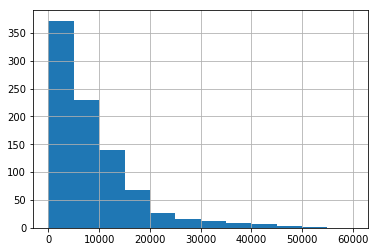

In [2]:
# 541674-4部件本次装机使用小时柱状图
data_y["部件本次装机使用小时"].hist(bins=12, range=(0,60000))

#  The second step : 部件生存概率曲线
乘积极限法kaplan_meier_estimator()：估计生存函数时对生存时间的分布没有要求，并且检验危险因素对生存时间的影响时采用的是非参数检验方法。优点：可以估计生存函数，可以比较两组或多组生存分布函数。可以分析危险因素对生存时间的影响，对生存时间的分布没有要求。
缺点：不能建立生存时间与危险因素之间的关系模型。

Text(0.5,1,'部件生存概率曲线')

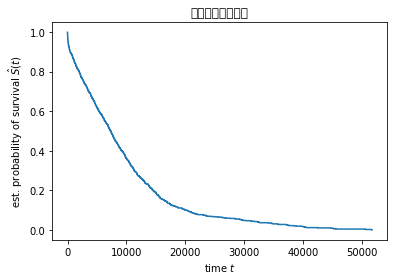

In [3]:
time, survival_prob = kaplan_meier_estimator(data_y["IsPlanned"], data_y["部件本次装机使用小时"])
plt.step(time, survival_prob, where="post")
# 生存函数S(t)的估计量(寿命大于t的概率)
# est. probability of survival --> 生存概率
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
# plt.title('Component survival probability curve')
plt.title('部件生存概率曲线')

# The third step ： 通过分层来考虑其他变量

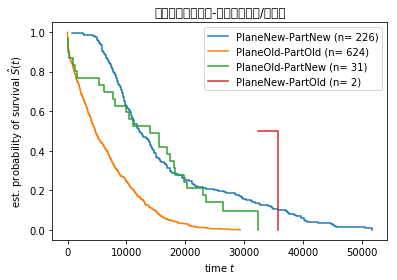

In [4]:
#部件生存概率曲线-按照新旧飞机/零部件
col = "PlanePartType"
y = data_y
x = data_x
for value in x[col].unique():
    mask = x[col] ==value
    time_cell, survival_prob_cell = kaplan_meier_estimator(y['IsPlanned'][mask],
                                                                             y['部件本次装机使用小时'][mask])
    plt.step(time_cell, survival_prob_cell, where="post", label="%s (n= %d)" % (value, mask.sum()))
    
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.title('部件生存概率曲线-按照新旧飞机/零部件')
plt.legend(loc="best")

Text(0.5,1,'部件生存概率曲线-按照最近维修单位')

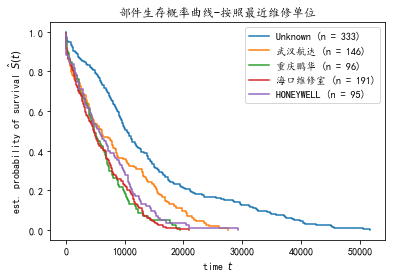

In [5]:
#部件生存概率曲线-按照最近维修单位

plt.rcParams['font.sans-serif'] = ['KaiTi'] # 指定默认字体
plt.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题

col = "最近送修公司"
filter1 = (data_x["最近送修公司"]!="GAMECO") & (data_x["最近送修公司"]!="广州航新") & (data_x["最近送修公司"]!="上海航新")
y = data_y[filter1]
x = data_x[filter1]

for value in x[col].unique():
    mask = x[col] == value
    time_cell, survival_prob_cell = kaplan_meier_estimator(y["IsPlanned"][mask], y["部件本次装机使用小时"][mask])
    plt.step(time_cell, survival_prob_cell, where="post", label="%s (n = %d)" % (value, mask.sum()))

plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="upper right")
plt.title("部件生存概率曲线-按照最近维修单位")

Text(0.5,1,'部件生存概率曲线-按部件装上使用小时数范围')

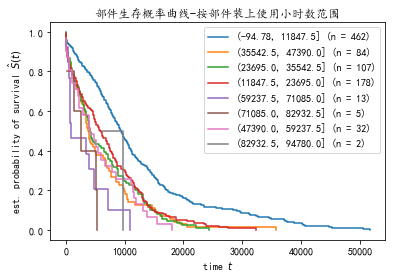

In [6]:
#部件生存概率曲线-按照“部件装上使用小时数”分类比较生存概率曲线

plt.rcParams['font.sans-serif'] = ['KaiTi'] # 指定默认字体
plt.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题

col = '部件装上使用小时数-Range'
y = data_y
x = data_x
for value in x[col].unique():
    mask = x[col] == value
    time_cell, survival_prob_cell = kaplan_meier_estimator(y["IsPlanned"][mask],
                                                           y["部件本次装机使用小时"][mask])
    plt.step(time_cell, survival_prob_cell, where="post", label="%s (n = %d)" % (value, mask.sum()))

plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="upper right")
plt.title('部件生存概率曲线-按部件装上使用小时数范围')

# The fourth step ：log-rank检验
通常不建议通过直观地比较估计的生存曲线来评估各组之间是否存在生存差异，因为这是非常主观的。统计检验，如log-rank检验通常更合适

In [7]:
from sksurv.compare import compare_survival
y = data_y.to_records(index=False)
group_indicator = data_x.loc[:, "安装年度"]
chisq, pvalue, stats, covar = compare_survival(y, group_indicator, return_stats=True)
display(chisq, pvalue, stats, covar)

458.2793813167874

3.259001225979646e-81

,counts,observed,expected,statistic
group,,,,
1993,5,4,18.694869,-14.694869
1994,1,1,3.297356,-2.297356
1995,1,1,4.663314,-3.663314
1996,1,1,3.732585,-2.732585
1997,3,3,9.605517,-6.605517
1998,9,9,30.278852,-21.278852
1999,9,9,24.043413,-15.043413
2000,6,5,15.023426,-10.023426
2001,4,3,13.280851,-10.280851


array([[ 1.74692543e+01, -1.63964016e-01, -3.25988724e-01,
        -2.42924869e-01, -5.03931924e-01, -1.42503084e+00,
        -9.42187997e-01, -5.35662553e-01, -6.43874643e-01,
        -1.92216043e+00, -2.56738311e+00, -1.09732968e+00,
        -7.35599812e-01, -5.90742667e-01, -7.33769316e-01,
        -5.10820461e-01, -5.96550484e-01, -6.68470642e-01,
        -8.24648819e-01, -9.08889414e-01, -8.32465752e-01,
        -4.49032439e-01, -1.23580198e-01, -9.37926771e-02,
        -2.56891654e-02, -4.76366000e-03],
       [-1.63964016e-01,  3.26122420e+00, -3.57907664e-02,
        -3.57907664e-02, -8.41997238e-02, -2.10533852e-01,
        -1.78959994e-01, -7.77255322e-02, -1.03508327e-01,
        -2.98490752e-01, -4.33441906e-01, -2.18307138e-01,
        -1.47754902e-01, -1.18148533e-01, -1.46867242e-01,
        -1.02164092e-01, -1.19310097e-01, -1.33694128e-01,
        -1.64929764e-01, -1.81777883e-01, -1.66493150e-01,
        -8.98064878e-02, -2.47160397e-02, -1.87585354e-02,
        -5.13

In [8]:
group_indicator = data_x.loc[:, "PlanePartType"]
chisq, pvalue, stats, covar = compare_survival(y, group_indicator, return_stats=True)
# pvalue
display(chisq,pvalue,stats,covar)

189.65690330228153

7.239743232866543e-41

,counts,observed,expected,statistic
group,,,,
PlaneNew-PartNew,226,203,364.930514,-161.930514
PlaneNew-PartOld,2,2,6.751717,-4.751717
PlaneOld-PartNew,31,27,41.779863,-14.779863
PlaneOld-PartOld,624,568,386.537906,181.462094


array([[ 177.87276129,   -4.03507869,  -19.82610724, -154.01157536],
       [  -4.03507869,    6.60819198,   -0.43182189,   -2.14129141],
       [ -19.82610724,   -0.43182189,   39.13869046,  -18.88076133],
       [-154.01157536,   -2.14129141,  -18.88076133,  175.0336281 ]])

In [9]:
group_indicator = data_x.loc[:, "最近送修公司"]
chisq, pvalue, stats, covar = compare_survival(y, group_indicator, return_stats=True)
pvalue

4.887497766849868e-29

In [10]:
group_indicator = data_x.loc[:, "部件装上使用小时数-Range"]
chisq, pvalue, stats, covar = compare_survival(y, group_indicator, return_stats=True)
pvalue

1.982930639026832e-19

# '##############################################################'

Text(0.5,0,'安装年度')

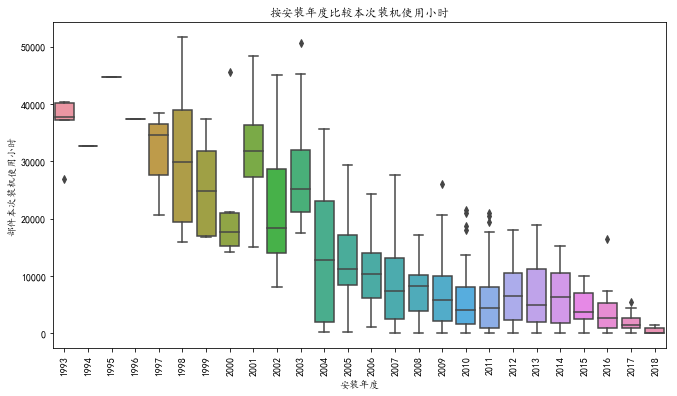

In [11]:
#按安装年度比较本次装机使用小时
import seaborn as sns
plt.rcParams['font.sans-serif'] = ['KaiTi'] # 指定默认字体
plt.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题

df=data1[['安装年度','部件本次装机使用小时']]
df.columns = ['Installation_year','components_this_time_installed_service_hours']
plt.subplots(figsize=(11, 6))
sns.boxplot(x="Installation_year", y="components_this_time_installed_service_hours", data=df)
_, xtext = plt.xticks()
for t in xtext:
    t.set_rotation("90")
plt.title('按安装年度比较本次装机使用小时')
plt.ylabel("部件本次装机使用小时")
plt.xlabel("安装年度")

整体趋势看，部件使用小时数逐年呈下降趋势

### 空值处理
因为要研究的 data_x 中没有这些列 所以不需要执行删除操作

In [12]:
# df.isnull().any()则会判断哪些”列”存在缺失值
display(data1.isnull().any())
print('#################################################')
# 含有空值的列
null_columns=data1.columns[data1.isnull().any()]
display(null_columns)
print('#################################################')
# 含有空值的列的空值数
sum_=data1[null_columns].isnull().sum()
display(sum_)
print('#################################################')

#删除含有空值的列
data_qukong =data1.drop(['故障描述'],axis=1)
data_qukong1 =data_qukong.drop(['故障处理'],axis=1)
data_qukong2 =data_qukong1.drop(['送修至拆下时间/FH'],axis=1)
data_qukong3 =data_qukong2.drop(['TLB号'],axis=1)
len(data_qukong3.columns)


机型                 False
制造序列号              False
机号                 False
参考类型               False
指令类型               False
件号                 False
序号                 False
章节号                False
非计划                False
故障确认               False
拆换原因               False
安装日期               False
部件装上飞行小时数          False
部件装上飞行循环数          False
部件装上使用小时数          False
部件装上使用循环数          False
拆换日期               False
部件拆下飞行小时数          False
部件拆下飞行循环数          False
部件拆下使用小时数          False
部件拆下使用循环数          False
故障描述                True
部件本次装机使用小时         False
故障处理                True
部件本次装机使用循环         False
装上件号               False
装上序号               False
最近送修公司             False
CY TSN             False
FH TSN             False
送修至拆下时间/FH          True
送修至拆下时间/CY         False
件号描述               False
DEF#               False
TLB号                True
IsPlanned          False
IsPlaneNew         False
IsPartNew          False
PlanePartType      False
安装年度               False


#################################################


Index(['故障描述', '故障处理', '送修至拆下时间/FH', 'TLB号'], dtype='object')

#################################################


故障描述          194
故障处理            1
送修至拆下时间/FH    341
TLB号           28
dtype: int64

#################################################


40

# '###############################################################'

# The fifth step : Cox的比例风险模型,测量生存模型的表现(一致性指数)


Cox 比例风险回归模型(Cox’s proportional hazards regression model) ， 简称Cox 回归模型,半参数法

不需要对生存时间的分布做出假定，但是却可以通过一个模型来分析生存时间的分布规律，以及危险因素对生存时间的影响，最著名的就是COX回归。

优点：可以估计生存函数，可以比较两组或多组生存分布函数。可以分析危险因素对生存时间的影响，可以建立生存时间与危险因素之间的关系模型，不需要事先知道生存时间的分布。

比例灾害模型是统计学中的一类生存模型。生存模型将事件发生前经过的时间与一个或多个与时间量相关的协变量联系起来。在比例危害模型中，单位增加的协变量的唯一影响是与危害率相乘。例如，服用一种药物可能会使一个人发生中风的危险率降低一半，或者，改变制造组件的材料可能会使失败的危险率增加一倍。其他类型的生存模型，如加速失效时间模型，不显示成比例的危险。加速失效时间模型描述了事件的生物或机械生命历史被加速(或减速)的情况。

生存模型可被视为由两部分组成:基本的基线危险函数，通常表示为lambda 0(t)，描述在协变量的基线水平上，每个时间单位的事件风险如何随时间变化;以及影响参数，描述危害如何随解释协变量而变化。一个典型的医学例子包括协变量，如治疗分配，以及患者特征，如研究开始时的年龄，性别，和其他疾病的存在，以减少变异性和/或控制混杂。

比例危险条件表明，协变量与危险的关系是相乘的。在最简单的平稳系数的情况下，例如，在任何给定的时间t，药物治疗可能使受试者的危险减半，而基线危险可能变化。但是请注意，这不会使主题的生存期延长一倍;协变量对生存期的精确影响取决于lambda 0(t)的类型。 协变量不限于二元预测因子;在一个连续的协变量x的情况下，通常假定危险指数反应;x每增加一个单位，危险就会按比例扩大。 Cox部分似然，如下图所示，是通过使用Breslow对基线风险函数的估计，将其插入完全似然，然后观察结果是两个因素的乘积而得到的。第一个因素是如下所示的部分似然，其中基线危害已经“消除”。第二个因素没有回归系数，仅通过截尾模式依赖于数据。因此，任何比例危害模型估计的协变量的影响都可以报告为危害比。 大卫·考克斯爵士观察到，如果比例危害假设成立(或者，假设成立)，那么就有可能在不考虑危害函数的情况下估算影响参数。这种处理生存数据的方法被称为Cox比例风险模型的应用，有时缩写为Cox模型或比例风险模型。然而，考克斯也指出，对比例危害假设的生物学解释可能相当棘手
### 测量生存模型的表现 一致性指数
- 1.concordance_index_censored
- 2.concordance_index_ipcw

一旦我们适应了生存模型，我们通常想要评估模型预测生存的能力。我们的测试数据通常也会受到审查，因此像均方根误差或相关性这样的指标是不合适的。相反，我们使用了被称为哈勒尔一致性指数 Harrell's concordance index或c指数的接受者工作特性(ROC)曲线下面积的泛化。 其解释与传统的ROC曲线二分类度量下的面积相同:

值0.5表示一个随机模型，值1.0表示一个完美模型，值0.0表示一个完全错误的模型。

In [13]:
x = data_x.copy()
cat_features =  ["机型", "安装年度","部件装上飞行小时数-Range","部件装上使用小时数-Range","FH TSN-Range", 
                 "最近送修公司","PlanePartType"]
for col in cat_features:
    x[col] = x[col].astype('category')
data_x_numeric = OneHotEncoder().fit_transform(x[cat_features])
display(data_x_numeric)

# 将数据aframe转换为NumPy记录数组。
y=data_y.to_records(index=False)
display(y)

estimator = CoxPHSurvivalAnalysis()
estimator.fit(data_x_numeric, y)

prediction = estimator.predict(data_x_numeric)
result = concordance_index_censored(y["IsPlanned"], y["部件本次装机使用小时"], prediction)
print(result[0])
result = concordance_index_ipcw(y, y, prediction)
print(result[0])

,机型=73N,机型=73Q,安装年度=1994,安装年度=1995,安装年度=1996,安装年度=1997,安装年度=1998,安装年度=1999,安装年度=2000,安装年度=2001,...,最近送修公司=HONEYWELL,最近送修公司=Unknown,最近送修公司=上海航新,最近送修公司=广州航新,最近送修公司=武汉航达,最近送修公司=海口维修室,最近送修公司=重庆鹏华,PlanePartType=PlaneNew-PartOld,PlanePartType=PlaneOld-PartNew,PlanePartType=PlaneOld-PartOld
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


rec.array([( True, 45588), ( True,   901), ( True, 45119), ( True, 44695),
           ( True,   151), ( True,   981), (False,  1591), ( True, 40114),
           ( True, 20609), ( True, 37429), ( True, 40649), ( True,  3431),
           ( True, 34627), ( True,  1164), ( True, 39734), ( True,   160),
           ( True,  3960), ( True, 32364), (False, 29257), ( True, 45191),
           ( True, 26345), ( True, 40390), ( True, 20236), ( True, 10126),
           ( True, 13960), ( True, 20937), ( True,    36), ( True, 15725),
           ( True,  6871), ( True, 20611), ( True, 13338), ( True, 13168),
           ( True,  2885), ( True,  1487), ( True,  6917), ( True, 18835),
           ( True, 14414), ( True,  3951), ( True,  9691), ( True,  9268),
           ( True,  9711), ( True,  3977), ( True, 10474), ( True,  1986),
           ( True,  1406), ( True, 11780), ( True, 14651), ( True,  3813),
           ( True, 13341), ( True, 11447), ( True,  2760), ( True, 12343),
           ( True, 15651)

0.7258153756552126
0.7256612570651125


# '#############################################################'

### ComponentwiseGradientBoostingSurvivalAnalysis

In [14]:
from sksurv.ensemble import ComponentwiseGradientBoostingSurvivalAnalysis

gbSA = ComponentwiseGradientBoostingSurvivalAnalysis(n_estimators=300, learning_rate=0.2)
gbSA.fit(data_x_numeric, y)
prediction2 = gbSA.predict(data_x_numeric)

result = concordance_index_censored(y["IsPlanned"], y["部件本次装机使用小时"], prediction2)
print(result[0])
result = concordance_index_ipcw(y, y, prediction)
print(result[0])

0.7087536400698894
0.7256612570651125


# '#############################################################'

# The sixth step ：多元的生存模式,来估计每个变量对生存的影响
在上述Kaplan-Meier方法中，我们通过根据一个变量将数据集分成更小的子组来估计多个生存曲线。如果我们想考虑超过1或2个变量，这种方法很快就变得不可行的，因为子组会变得非常小。相反，我们可以使用一个线性模型，Cox的比例风险模型，来估计每个变量对生存的影响。但是，首先需要将数据集中的分类变量转换为数值。
### 特征选择:哪个变量最有预测性?
我们的模型的c指数表明，模型的表现明显好于随机，但也远远不够完美。

特征选择:哪个变量最有预测性? 上述模型考虑了所有可能的预测变量。接下来，我们要调查哪一个单一变量是最好的风险预测。因此，我们分别对每个变量拟合Cox模型，并将c-index记录在训练集上。

根据pd.Series(scores, index=data_x_numeric.columns).sort_values(ascending=False)的输出，可以看出
PlanePartType=PlaneOld-PartOld是最好的变量，而安装年度=2014及以下的变量本身几乎没有预测能力。

In [15]:
def fit_and_score_features(X, y):
    n_features = X.shape[1]
    scores = np.empty(n_features)
    m = CoxPHSurvivalAnalysis()
    for j in range(n_features):
        Xj = X[:, j:j+1]
        m.fit(Xj, y)
        scores[j] = m.score(Xj, y)
    return scores

scores_ = fit_and_score_features(data_x_numeric.values, y)

ind = pd.Series(scores_, index=data_x_numeric.columns).sort_values(ascending=False)
ind

PlanePartType=PlaneOld-PartOld           0.629929
最近送修公司=Unknown                           0.596136
部件装上飞行小时数-Range=(7706.375, 15412.75]     0.547526
最近送修公司=海口维修室                             0.546589
机型=73N                                   0.541009
机型=73Q                                   0.530103
部件装上飞行小时数-Range=(15412.75, 23119.125]    0.527123
部件装上使用小时数-Range=(11847.5, 23695.0]       0.525990
安装年度=2011                                0.523339
部件装上使用小时数-Range=(35542.5, 47390.0]       0.522314
部件装上使用小时数-Range=(23695.0, 35542.5]       0.522174
最近送修公司=重庆鹏华                              0.521131
安装年度=2003                                0.520753
安装年度=2010                                0.519884
FH TSN-Range=(38377.699, 51170.265]      0.518430
安装年度=2002                                0.517497
FH TSN-Range=(25585.132, 38377.699]      0.515135
最近送修公司=HONEYWELL                         0.513992
安装年度=2005                                0.513484
安装年度=2016                                0.513419


# The seventh step : 输入样例数据可以预测不同情况下的生存概率曲线
predict_survival_function():
使用拟合模型，我们可以通过将适当的数据矩阵传递给估计器的predict_survival_function方法来预测特定患者的生存函数。


In [16]:
# 随机抽取四个特定患者，查看其生存函数
x_new = data_x_numeric.loc[[46,77,200,593]]
x_new

,机型=73N,机型=73Q,安装年度=1994,安装年度=1995,安装年度=1996,安装年度=1997,安装年度=1998,安装年度=1999,安装年度=2000,安装年度=2001,...,最近送修公司=HONEYWELL,最近送修公司=Unknown,最近送修公司=上海航新,最近送修公司=广州航新,最近送修公司=武汉航达,最近送修公司=海口维修室,最近送修公司=重庆鹏华,PlanePartType=PlaneNew-PartOld,PlanePartType=PlaneOld-PartNew,PlanePartType=PlaneOld-PartOld
46,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
77,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
200,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
593,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [17]:
y[[46,77,200,593]]

rec.array([( True, 14651), ( True,  4944), (False,  1103), ( True,  6657)],
          dtype=[('IsPlanned', '?'), ('部件本次装机使用小时', '<i4')])

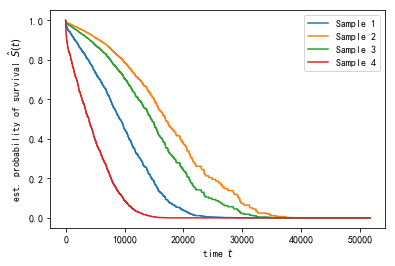

In [18]:
pred_surv = estimator.predict_survival_function(x_new)

for i, c in enumerate(pred_surv):
    plt.step(c.x, c.y, where="post", label="Sample %d" % (i + 1))
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")

# '############################################################'

### 选择几个特征对于模型来说最好(待解决)
接下来，我们希望通过排除不相关的特性来构建一个简洁的模型。我们可以使用上面的排名，但需要确定最佳的分界点是什么。幸运的是，scikit-learn内置了对执行网格搜索的支持。 首先，我们创建一个将所有部分放在一起的管道。

In [19]:
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline
pipe = Pipeline([
    ('encode',OneHotEncoder()),
    ('select',SelectKBest(fit_and_score_features,k=10)),
    ('model',CoxPHSurvivalAnalysis())
])

from sklearn.model_selection import GridSearchCV
param_grid = {'select__k': np.arange(1, data_x_numeric.shape[1] +1)}
gcv = GridSearchCV(pipe, param_grid, return_train_score=True, cv=3, iid=True)
gcv

gcv.fit(x, y)

C:\Users\shuangyang.luo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:530: FutureWarning: From version 0.22, errors during fit will result in a cross validation score of NaN by default. Use error_score='raise' if you want an exception raised or error_score=np.nan to adopt the behavior from version 0.22.
  FutureWarning)


LinAlgError: Matrix is singular.

# '##########################################################'

# The eighth step : 给定时间点列表下的ROC下的累积/动态区域的估计
### 时间相关区域 : Time-dependent Area under the ROC
接收机工作特性曲线(ROC曲线)下面积是二分类任务常用的性能指标。在医学领域，它经常被用来确定估计的风险评分如何能够很好地将患病患者(病例)与健康患者(对照组)区分开来。给定一个预测风险评分̂f ^, ROC曲线比较假阳性率(1 -特异性)对真阳性率(灵敏度)̂f ^的每个可能值。

当将ROC曲线延伸至持续的结果，特别是生存时间时，患者的疾病状态通常不是固定的，并且会随着时间的推移而改变:受试者在登记时通常是健康的，但在以后的某个时间点可能会患病。因此，敏感性和特异性成为依赖于时间的度量。在这里，我们考虑在给定时间点tt的累积情况和动态控制，这导致了在tt时的依赖于时间的累积/动态ROC。累积病例是所有个体在tt (ti≤tti≤t)之前或在tt (ti≤tti≤t)时经历过一次事件，而动态对照是那些有ti>tti>t的个体。通过计算tt时累积/动态ROC下的面积，我们可以确定一个模型在多大程度上能够区分在给定时间(ti≤tti≤t)失败的受试者和在此之后失败的受试者(ti>tti>t)。因此，如果想要预测事件在tt之前而不是在tt的特定时间点上的发生，这是最相关的。

函数实现了对给定时间点列表下的ROC下的累积/动态区域的估计。图中以虚线表示各时间点受时间影响的ROC下的估计面积和各时间点的平均值。【我们首先将个体的实值特征作为风险评分，而不实际拟合生存模型】。因此，我们获得了"安装年度","部件装上飞行小时数","部件装上使用小时数","FH TSN"在每个时间点从对照组中区分零件好坏的能力的估计值。查看不同参数对于预测影响。

首先，我们加载数据并将其分成训练集和测试集，以评估标记泛化的效果。

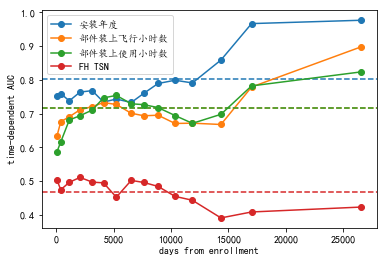

In [21]:
from sklearn.model_selection import train_test_split
from sksurv.metrics import (concordance_index_censored,
                            concordance_index_ipcw,
                            cumulative_dynamic_auc)

data_x = data1[["安装年度","部件装上飞行小时数","部件装上使用小时数","FH TSN"]]
num_columns = ["安装年度","部件装上飞行小时数","部件装上使用小时数","FH TSN"]

y = data_y.to_records(index=False)
x_train, x_test, y_train, y_test = train_test_split(data_x, y, test_size=0.2)#, random_state=1)
x_train = x_train.values
x_test = x_test.values

# 与Uno对上述一致性指数的估计类似，我们在选择要评估ROC at的测试数据和时间点时需要小心一点，因为估计量依赖于截尾加权的逆概率。
# 首先，我们要检查测试数据的观测时间是否在训练数据的观测时间范围内。在选择时间点评价ROC时，一定要记住选择最后一个时间点，使最后
#一个时间点之后被截尾的概率为非零。在上面的模拟研究中，我们将上界设置为最大事件时间，这里我们使用了一种更保守的方法，将上界
#设置为观测时间点的80%百分位数，因为截尾率相当大，为72.5%。注意，这种方法也适用于选择concordance_index_ipcw中的tau。
y_events_train = y_train[y_train['IsPlanned']==False]
train_min, train_max = y_events_train["部件本次装机使用小时"].min(), y_events_train["部件本次装机使用小时"].max()
y_events_test = y_test[y_test['IsPlanned']==False]
test_min, test_max = y_events_test["部件本次装机使用小时"].min(), y_events_test["部件本次装机使用小时"].max()
assert train_min <= test_min < test_max < train_max, \
    "time range or test data is not within time range of training data."

times = np.percentile(data_y["部件本次装机使用小时"], np.linspace(5, 95, 15))

def plot_cumulative_dynamic_auc(risk_score, label, color=None):
    
    auc, mean_auc = cumulative_dynamic_auc(y_train, y_test, risk_score, times)

    plt.plot(times, auc, marker="o", color=color, label=label)
    plt.xlabel("days from enrollment")
    plt.ylabel("time-dependent AUC")
    plt.axhline(mean_auc, color=color, linestyle="--")
    plt.legend()

    
for i, col in enumerate(num_columns):

    plot_cumulative_dynamic_auc(x_test[:, i], col, color="C{}".format(i))
    ret = concordance_index_ipcw(y_train, y_test, x_test[:, i], tau=times[-1])

“cumulative_dynamic_auc”分析，整体来看“安装年度”和“飞行/使用小时数”的影响度较高，而“FH TSN”的影响度较低 15000小时之后， “安装年度”和“飞行/使用小时数”的重要度逐渐上升，而“FH TSN”的重要度则逐渐下降。

接下来，我们将拟合一个实际的生存模型来预测退伍军人管理局肺癌试验的死亡风险。在拟合Cox比例风险模型后，我们希望评估该模型在登记后6个月的时间间隔内，如何区分生还者和死者。

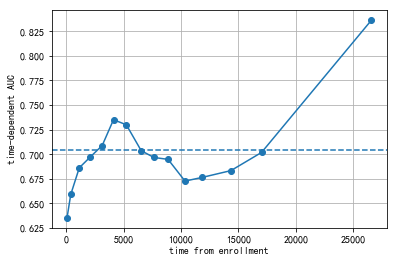

In [22]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sksurv.metrics import (concordance_index_censored,
                            concordance_index_ipcw,
                            cumulative_dynamic_auc)
import warnings
warnings.filterwarnings("ignore", category=Warning)
data_x = data1[["机型","安装年度","部件装上飞行小时数","部件装上使用小时数","FH TSN", "最近送修公司","PlanePartType"]]

cat_features = ["机型", "安装年度", "最近送修公司","PlanePartType"]

for col in cat_features:
    data_x[col] =data_x[col].astype('category')
    
y = data_y.to_records(index=False)
va_x, va_y = data_x, y

cph = make_pipeline(OneHotEncoder(), CoxnetSurvivalAnalysis())
cph.fit(va_x, va_y)

# estimate performance on training data, thus use `va_y` twice.
va_auc, va_mean_auc = cumulative_dynamic_auc(va_y, va_y, cph.predict(va_x), times)

plt.plot(times, va_auc, marker="o")
plt.axhline(va_mean_auc, linestyle="--")
plt.xlabel("time from enrollment")
plt.ylabel("time-dependent AUC")
plt.grid(True)

从图中可以看出，该模型的AUC平均为~0.705(虚线)，运行良好。“cumulative_dynamic_auc”分析，查看模型整体的预测效果。
 随着预测时间的增长，模型整体效果逐渐上升，在5000小时左右的预测效果最佳，随后逐渐下降到10000小时，之后再次呈上升趋势。